### Indicadores de Sucesso com Visualização Consolidada

In [1]:
from pyspark.sql import SparkSession, Row, functions as F
import pandas as pd
import matplotlib.pyplot as plt

/home/jose_fontes/case/ifood_case/.venv/lib/python3.10/site-packages/numpy/_core/getlimits.py:551: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


25/05/20 14:37:53 WARN Utils: Your hostname, EBR399 resolves to a loopback address: 127.0.1.1; using 192.168.18.5 instead (on interface wifi2)
25/05/20 14:37:53 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/20 14:37:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


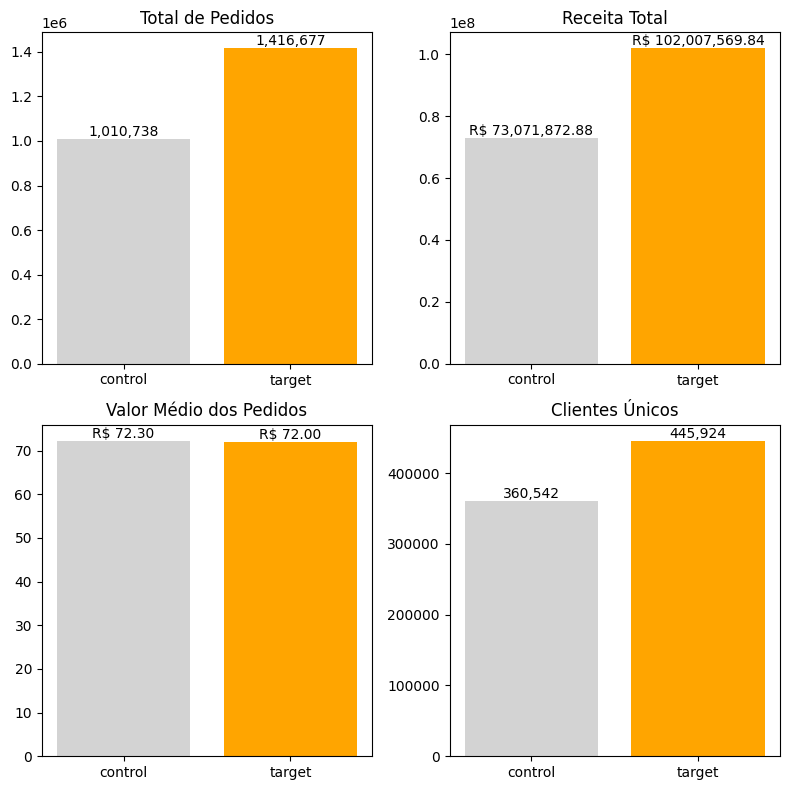

In [2]:


# Inicializa Spark
spark = SparkSession.builder.appName("ifood_abtest_visualizacao").getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

df_orders = spark.read.parquet("trusted_data/processed_orders.parquet")
df_abtest = spark.read.parquet("trusted_data/processed_abtest.parquet")

df_joined = df_orders.join(df_abtest, on="customer_id", how="inner")

agg_df = df_joined.groupBy("is_target").agg(
    F.countDistinct("order_id").alias("total_orders"),
    F.sum("order_total_amount").alias("total_revenue"),
    (F.sum("order_total_amount") / F.countDistinct("order_id")).alias("avg_order_value"),
    F.countDistinct("customer_id").alias("unique_customers")
)
group_metrics = agg_df.toPandas()

fig, axes = plt.subplots(2, 2, figsize=(8, 8))

axes[0, 0].bar(group_metrics['is_target'], group_metrics['total_orders'], color=['lightgray', 'orange'])
axes[0, 0].set_title('Total de Pedidos')
for i, v in enumerate(group_metrics['total_orders']):
    axes[0, 0].text(i, v, f'{v:,}', ha='center', va='bottom')

axes[0, 1].bar(group_metrics['is_target'], group_metrics['total_revenue'], color=['lightgray', 'orange'])
axes[0, 1].set_title('Receita Total')
for i, v in enumerate(group_metrics['total_revenue']):
    axes[0, 1].text(i, v, f'R$ {v:,.2f}', ha='center', va='bottom')

axes[1, 0].bar(group_metrics['is_target'], group_metrics['avg_order_value'], color=['lightgray', 'orange'])
axes[1, 0].set_title('Valor Médio dos Pedidos')
for i, v in enumerate(group_metrics['avg_order_value']):
    axes[1, 0].text(i, v, f'R$ {v:.2f}', ha='center', va='bottom')

axes[1, 1].bar(group_metrics['is_target'], group_metrics['unique_customers'], color=['lightgray', 'orange'])
axes[1, 1].set_title('Clientes Únicos')
for i, v in enumerate(group_metrics['unique_customers']):
    axes[1, 1].text(i, v, f'{v:,}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

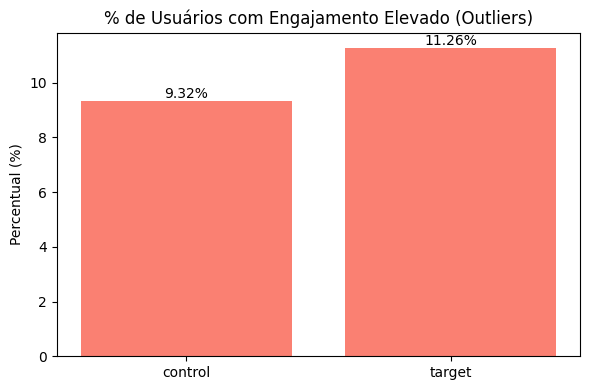

In [3]:
pedidos_por_usuario_df = df_joined.groupBy("customer_id", "is_target").agg(
    F.countDistinct("order_id").alias("pedidos_usuario")
)


pedidos_amostrados = pedidos_por_usuario_df.filter(F.col("pedidos_usuario") <= 50).toPandas()

q1 = pedidos_amostrados["pedidos_usuario"].quantile(0.25)
q3 = pedidos_amostrados["pedidos_usuario"].quantile(0.75)
iqr = q3 - q1
limite_outlier = q3 + 1.5 * iqr


outliers_df = pedidos_por_usuario_df.filter(F.col("pedidos_usuario") > limite_outlier)
outliers_por_grupo = outliers_df.groupBy("is_target").agg(F.count("customer_id").alias("usuarios_outlier"))
total_por_grupo = pedidos_por_usuario_df.groupBy("is_target").agg(F.count("customer_id").alias("total_usuarios"))


outlier_pct_df = outliers_por_grupo.join(total_por_grupo, on="is_target") \
    .withColumn("percentual_outliers", F.col("usuarios_outlier") / F.col("total_usuarios") * 100)

# Converte para pandas e plota
outlier_pct_pd = outlier_pct_df.toPandas()
fig, ax = plt.subplots(figsize=(6,4))
colors = ["lightgray" if not x else "salmon" for x in outlier_pct_pd["is_target"]]
ax.bar(outlier_pct_pd["is_target"], outlier_pct_pd["percentual_outliers"], color=colors)
ax.set_title("% de Usuários com Engajamento Elevado (Outliers)")
ax.set_ylabel("Percentual (%)")
for i, v in enumerate(outlier_pct_pd["percentual_outliers"]):
    ax.text(i, v, f"{v:.2f}%", ha='center', va='bottom')
plt.tight_layout()
plt.show()

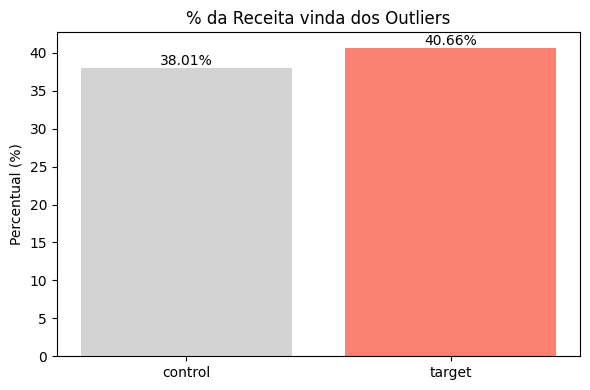

In [4]:
outlier_ids = [row["customer_id"] for row in outliers_df.select("customer_id").distinct().collect()]

outlier_id_df = spark.createDataFrame([Row(customer_id=cid) for cid in outlier_ids])

receita_outliers_df = df_joined.join(outlier_id_df, on="customer_id", how="inner")

receita_outliers = receita_outliers_df.groupBy("is_target").agg(
    F.sum("order_total_amount").alias("receita_outlier")
).toPandas()

receita_total = df_joined.groupBy("is_target").agg(
    F.sum("order_total_amount").alias("receita_total")
).toPandas()

contribuicao = receita_total.merge(receita_outliers, on="is_target")
contribuicao["percentual_outlier"] = 100 * contribuicao["receita_outlier"] / contribuicao["receita_total"]


fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(contribuicao["is_target"], contribuicao["percentual_outlier"], color=["lightgray", "salmon"])
ax.set_title("% da Receita vinda dos Outliers")
ax.set_ylabel("Percentual (%)")
for i, v in enumerate(contribuicao["percentual_outlier"]):
    ax.text(i, v, f"{v:.2f}%", ha="center", va="bottom")
plt.tight_layout()
plt.show()


In [5]:
for idx, row in contribuicao.iterrows():
    grupo = row["is_target"]
    receita_outlier = row["receita_outlier"]
    receita_total = row["receita_total"]
    percentual = row["percentual_outlier"]
    print(f"Grupo: {grupo}")
    print(f"Receita dos outliers: R$ {receita_outlier:,.2f}")
    print(f"Receita total do grupo: R$ {receita_total:,.2f}")
    print(f"Percentual: {percentual:.2f}%")
    print("-" * 35)


Grupo: control
Receita dos outliers: R$ 27,775,310.23
Receita total do grupo: R$ 73,071,872.88
Percentual: 38.01%
-----------------------------------
Grupo: target
Receita dos outliers: R$ 41,477,011.04
Receita total do grupo: R$ 102,007,569.84
Percentual: 40.66%
-----------------------------------



 Top 3 Estados por Receita — Controle


+---------+----------------------+--------------------+
|is_target|delivery_address_state|       receita_total|
+---------+----------------------+--------------------+
|  control|                    SP|3.2223646149996348E7|
|  control|                    RJ|1.6186106620000131E7|
|  control|                    MG|  2932693.9199999184|
+---------+----------------------+--------------------+
only showing top 3 rows


 Top 3 Estados por Receita — Target


+---------+----------------------+--------------------+
|is_target|delivery_address_state|       receita_total|
+---------+----------------------+--------------------+
|   target|                    SP| 4.515429504999273E7|
|   target|                    RJ|2.3050074479998548E7|
|   target|                    MG|   4118441.109999994|
+---------+----------------------+--------------------+
only showing top 3 rows



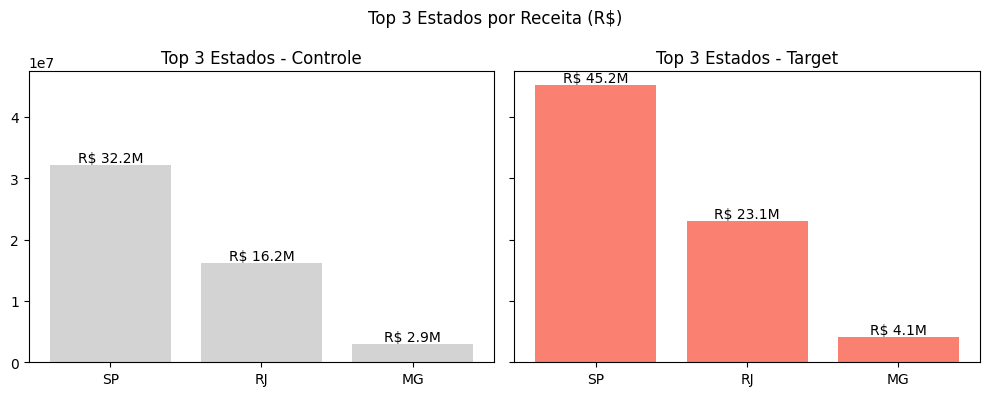

In [6]:
# TOP 3 ESTADOS POR RECEITA
top_estados = df_joined.groupBy("is_target", "delivery_address_state").agg(
    F.sum("order_total_amount").alias("receita_total")
).orderBy("is_target", F.desc("receita_total"))

print("\n Top 3 Estados por Receita — Controle")
top_estados.filter(F.col("is_target") == "control").show(3)
print("\n Top 3 Estados por Receita — Target")
top_estados.filter(F.col("is_target") == "target").show(3)

# Pega os dados para cada grupo
top3_estados_control = top_estados.filter(F.col("is_target") == "control").orderBy(F.desc("receita_total")).limit(3).toPandas()
top3_estados_target  = top_estados.filter(F.col("is_target") == "target").orderBy(F.desc("receita_total")).limit(3).toPandas()

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

# Controle
axes[0].bar(top3_estados_control['delivery_address_state'], top3_estados_control['receita_total'], color="lightgray")
axes[0].set_title('Top 3 Estados - Controle')
for i, v in enumerate(top3_estados_control['receita_total']):
    axes[0].text(i, v, f"R$ {v/1e6:.1f}M", ha="center", va="bottom")

# Target
axes[1].bar(top3_estados_target['delivery_address_state'], top3_estados_target['receita_total'], color="salmon")
axes[1].set_title('Top 3 Estados - Target')
for i, v in enumerate(top3_estados_target['receita_total']):
    axes[1].text(i, v, f"R$ {v/1e6:.1f}M", ha="center", va="bottom")

fig.suptitle("Top 3 Estados por Receita (R$)")
plt.tight_layout()
plt.show()


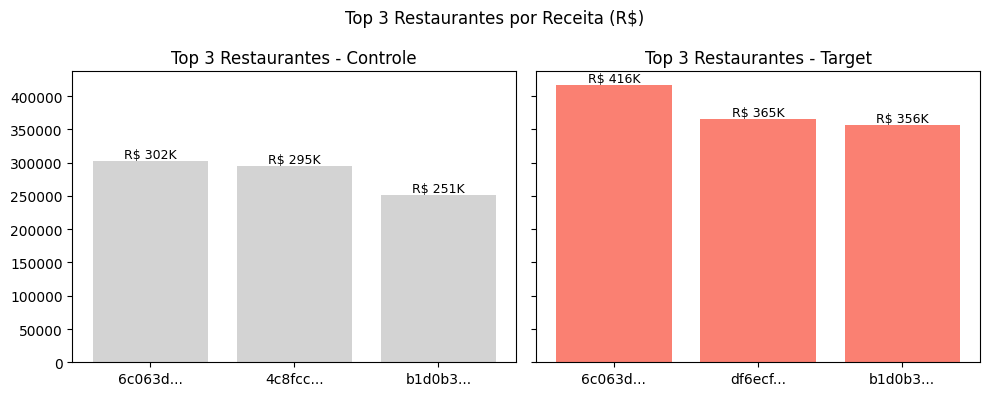

In [9]:
# 1. Agrega o valor total por restaurante e grupo
top_restaurantes = (
    df_joined.groupBy("is_target", "merchant_id")
    .agg(F.sum("order_total_amount").alias("receita_total"))
    .orderBy("is_target", F.desc("receita_total"))
)

# 2. Filtra top 3 restaurantes de cada grupo e converte para pandas
top3_rest_control = (
    top_restaurantes
    .filter(F.col("is_target") == "control")
    .limit(3)
    .toPandas()
)

top3_rest_target = (
    top_restaurantes
    .filter(F.col("is_target") == "target")
    .limit(3)
    .toPandas()
)

# 3. Cria rótulos encurtados para o gráfico
def short_id(x):
    return x[:6] + "..."

top3_rest_control['label'] = top3_rest_control['merchant_id'].apply(short_id)
top3_rest_target['label']  = top3_rest_target['merchant_id'].apply(short_id)

# 4. Plota o gráfico lado a lado
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

axes[0].bar(top3_rest_control['label'], top3_rest_control['receita_total'], color="lightgray")
axes[0].set_title('Top 3 Restaurantes - Controle')
for i, v in enumerate(top3_rest_control['receita_total']):
    axes[0].text(i, v, f"R$ {v/1e3:.0f}K", ha="center", va="bottom", fontsize=9)

axes[1].bar(top3_rest_target['label'], top3_rest_target['receita_total'], color="salmon")
axes[1].set_title('Top 3 Restaurantes - Target')
for i, v in enumerate(top3_rest_target['receita_total']):
    axes[1].text(i, v, f"R$ {v/1e3:.0f}K", ha="center", va="bottom", fontsize=9)

fig.suptitle("Top 3 Restaurantes por Receita (R$)")
plt.tight_layout()
plt.show()

In [10]:

receita_total_grupo = df_joined.groupBy("is_target").agg(
    F.sum("order_total_amount").alias("receita_total")
).toPandas()

# Para cada grupo, calcula o percentual da receita dos TOP 3 restaurantes
def percentual_receita_top3(top3_rest_df, is_target_label):
    receita_total = receita_total_grupo[receita_total_grupo["is_target"] == is_target_label]["receita_total"].values[0]
    soma_top3 = top3_rest_df["receita_total"].sum()
    percentual = 100 * soma_top3 / receita_total
    return percentual, soma_top3, receita_total


pct_ctrl, soma_ctrl, total_ctrl = percentual_receita_top3(top3_rest_control, "control")
print(f"Top 3 Controle: R$ {soma_ctrl:,.0f} ({pct_ctrl:.2f}% da receita do grupo de controle, total R$ {total_ctrl:,.0f})")

pct_trg, soma_trg, total_trg = percentual_receita_top3(top3_rest_target, "target")
print(f"Top 3 Target: R$ {soma_trg:,.0f} ({pct_trg:.2f}% da receita do grupo target, total R$ {total_trg:,.0f})")


Top 3 Controle: R$ 847,804 (1.16% da receita do grupo de controle, total R$ 73,071,873)
Top 3 Target: R$ 1,137,588 (1.12% da receita do grupo target, total R$ 102,007,570)


In [11]:
# Número total de restaurantes distintos por grupo (usando df_joined)
restaurantes_por_grupo = df_joined.groupBy("is_target").agg(
    F.countDistinct("merchant_id").alias("restaurantes_distintos")
).toPandas()

print(restaurantes_por_grupo)


  is_target  restaurantes_distintos
0   control                    7196
1    target                    7227


In [12]:
for idx, row in restaurantes_por_grupo.iterrows():
    grupo = row["is_target"]
    total_restaurantes = row["restaurantes_distintos"]
    print(f"Grupo {grupo}: {total_restaurantes} restaurantes únicos")
    print(f"Top 3 representam: {3/total_restaurantes*100:.2f}% dos restaurantes do grupo\n")


Grupo control: 7196 restaurantes únicos
Top 3 representam: 0.04% dos restaurantes do grupo

Grupo target: 7227 restaurantes únicos
Top 3 representam: 0.04% dos restaurantes do grupo



### Análise de Viabilidade Financeira

In [13]:


# Premissas adotadas:
# - Custo médio do cupom concedido por pedido: R$ 10,00
# - Apenas o grupo Target recebeu cupons
# - Considera-se que todos os pedidos do grupo Target utilizaram cupom

# Receita incremental: diferença entre receita do grupo Target e Controle
target_revenue = group_metrics.loc[group_metrics['is_target'] == 'target', 'total_revenue'].values[0]
control_revenue = group_metrics.loc[group_metrics['is_target'] == 'control', 'total_revenue'].values[0]
receita_incremental = target_revenue - control_revenue

# Custo total estimado da campanha com cupom
num_pedidos_target = group_metrics.loc[group_metrics['is_target'] == 'target', 'total_orders'].values[0]
custo_unitario_cupom = 10.0
custo_total_campanha = num_pedidos_target * custo_unitario_cupom

# ROI: retorno sobre o investimento
roi = (receita_incremental - custo_total_campanha) / custo_total_campanha

print("Análise de Viabilidade Financeira da Campanha:")
print(f"Receita Incremental: R$ {receita_incremental:,.2f}".replace(",", "v").replace(".", ",").replace("v", "."))
print(f"Custo Estimado da Campanha: R$ {custo_total_campanha:,.2f}".replace(",", "v").replace(".", ",").replace("v", "."))
print(f"ROI Estimado: {roi:.2%}")


Análise de Viabilidade Financeira da Campanha:
Receita Incremental: R$ 28.935.696,96
Custo Estimado da Campanha: R$ 14.166.770,00
ROI Estimado: 104.25%


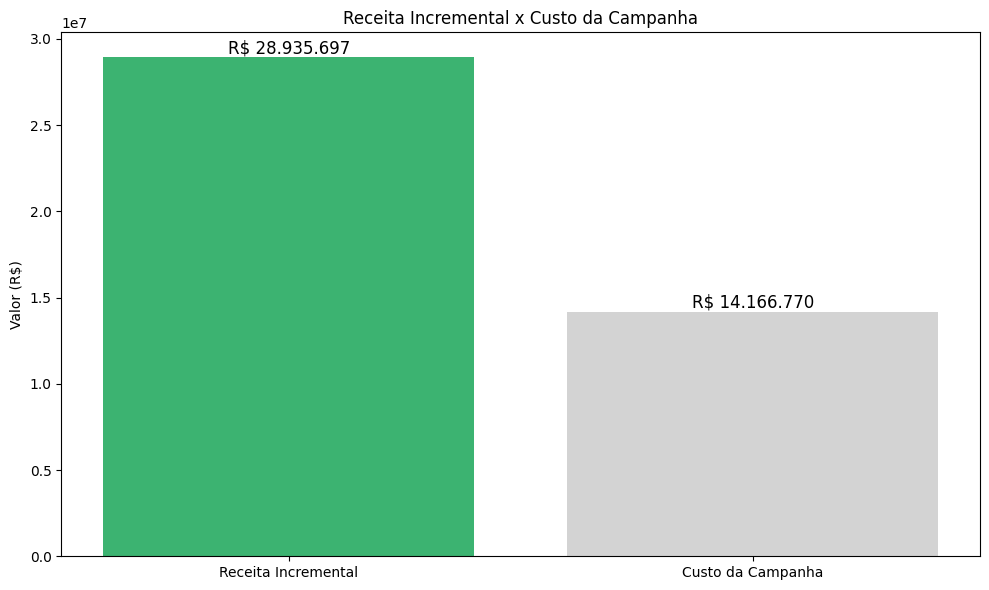

In [14]:

dados = [receita_incremental, custo_total_campanha]
labels = ['Receita Incremental', 'Custo da Campanha']
colors = ['mediumseagreen', 'lightgray']

fig, ax = plt.subplots(figsize=(10,6))
bars = ax.bar(labels, dados, color=colors)
ax.set_title("Receita Incremental x Custo da Campanha")
ax.set_ylabel("Valor (R$)")
for i, v in enumerate(dados):
    ax.text(i, v, f'R$ {v:,.0f}'.replace(",", "v").replace(".", ",").replace("v", "."), ha='center', va='bottom', fontsize=12)
plt.tight_layout()
plt.show()
